## Proyecto profesional 2
 
 Análisis de datos correspondiente al trabajo de:
 
 * Carlos Adrián Alarcón
 * Keren Jemima Arteaga
 
 A continuación, se presenta el sustento numérico de las causas

In [69]:
## Eliminar advertencias de los paquetes

import warnings
warnings.filterwarnings("ignore")

In [70]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

Cargar los datos brindados por la empresa

In [71]:
## Cargar librerias

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('C:/Users/Adrián Alarcón/OneDrive - Universidad Peruana de Ciencias/UPC/2022-0/PIA1/Data/data_reporte_final.csv')
filas = data.shape[0]
columnas = data.shape[1]
print('El dataset tiene',filas, 'filas y',columnas,'columnas')

El dataset tiene 43467 filas y 62 columnas


### Análisis exploratorio

In [72]:
columnas = list(data.columns)
nuevas_cols = list(map(lambda x: x.lower(), columnas))
data.columns = nuevas_cols

### Considerar solo incidencias cerradas

data_df = data[data['estado']=='Cerrada']

### Limpieza de datos 

data_df['tiempo de cierre (horas / minutos)'] = data_df['tiempo de cierre (horas / minutos)'].str.strip()
tiempos = data_df['tiempo de cierre (horas / minutos)'].str.split('h ')

tiempo_cierre = []


for i in range(0,len(tiempos)):
    minutos = float(tiempos.iloc[i][1].replace('m',''))
    horas = float(tiempos.iloc[i][0])
    tiempo_total = round(horas + (minutos/60),2)
    tiempo_cierre.append(tiempo_total)
    
data_df['tiempo_cierre_horas'] = tiempo_cierre


sla_horas = []
for i in range(0, len(tiempos)):
    texto = str(data_df['sla'].iloc[i])
    sla = texto[texto.find('(')+1:texto.find('h)')]
    if sla != 'na':
        sla_nuevo = round(float(sla),2)
        sla_horas.append(sla_nuevo)
    else:
        sla = np.nan
        sla_horas.append(sla)
        
data_df['sla_horas'] = sla_horas

In [73]:
### Anonimizar data

from anonymizedf.anonymizedf import anonymize

data_df = data_df.rename(columns = {'técnico de 2ª línea':'tecnico'})
an = anonymize(data_df)
data_df = an.fake_categories('tecnico')
data_df = data_df.rename(columns = {'Fake_tecnico':'tecnico_new'})


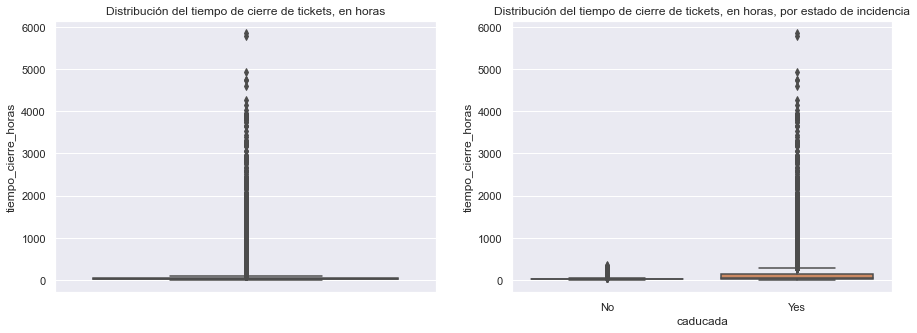

In [74]:
### Distribución del tiempo de cierre de tickets real
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(y = data_df['tiempo_cierre_horas'], ax = ax1)
sns.boxplot(y = data_df['tiempo_cierre_horas'], x = data_df['caducada'], ax = ax2)
ax1.title.set_text('Distribución del tiempo de cierre de tickets, en horas')
ax2.title.set_text('Distribución del tiempo de cierre de tickets, en horas, por estado de incidencia')
plt.show()


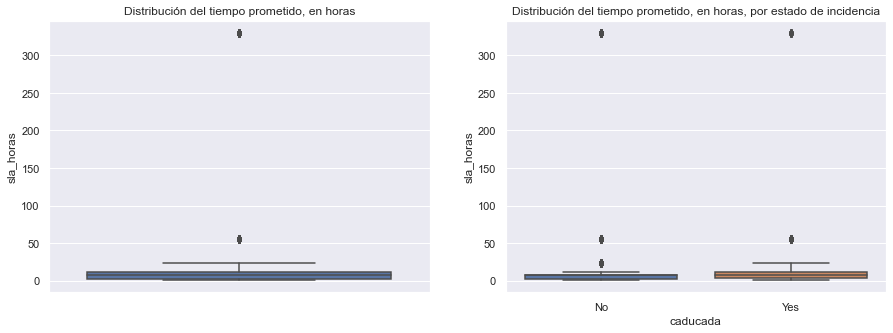

In [75]:
### Distribución del tiempo prometido (SLA)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(y = data_df['sla_horas'], ax = ax1)
sns.boxplot(y = data_df['sla_horas'], x = data_df['caducada'], ax = ax2)
ax1.title.set_text('Distribución del tiempo prometido, en horas')
ax2.title.set_text('Distribución del tiempo prometido, en horas, por estado de incidencia')
plt.show()

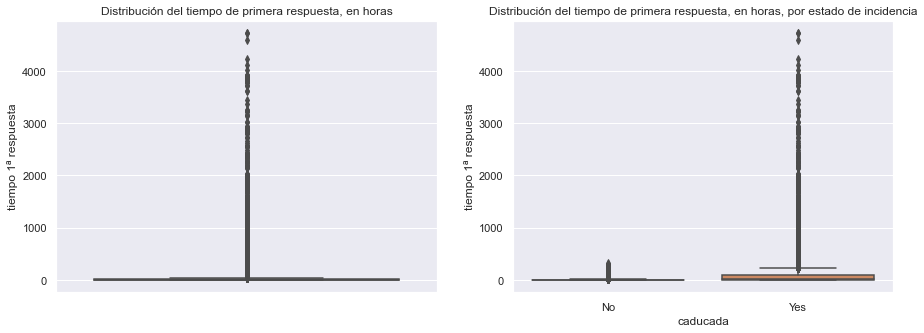

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(y = data_df['tiempo 1ª respuesta'], ax = ax1)
sns.boxplot(y = data_df['tiempo 1ª respuesta'], x = data_df['caducada'], ax = ax2)
ax1.title.set_text('Distribución del tiempo de primera respuesta, en horas')
ax2.title.set_text('Distribución del tiempo de primera respuesta, en horas, por estado de incidencia')
plt.show()


Text(0.5, 1.0, 'Relación entre tiempo de 1ra respuesta y tiempo de cierre')

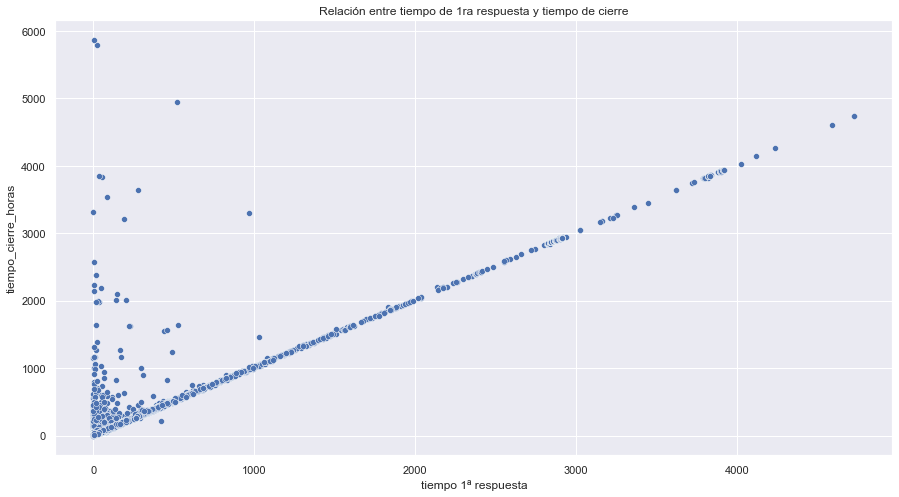

In [93]:
sns.scatterplot(x = data_df['tiempo 1ª respuesta'], y = data_df['tiempo_cierre_horas'])
plt.title('Relación entre tiempo de 1ra respuesta y tiempo de cierre')

caducada
No     24690
Yes    13972
Name: código, dtype: int64


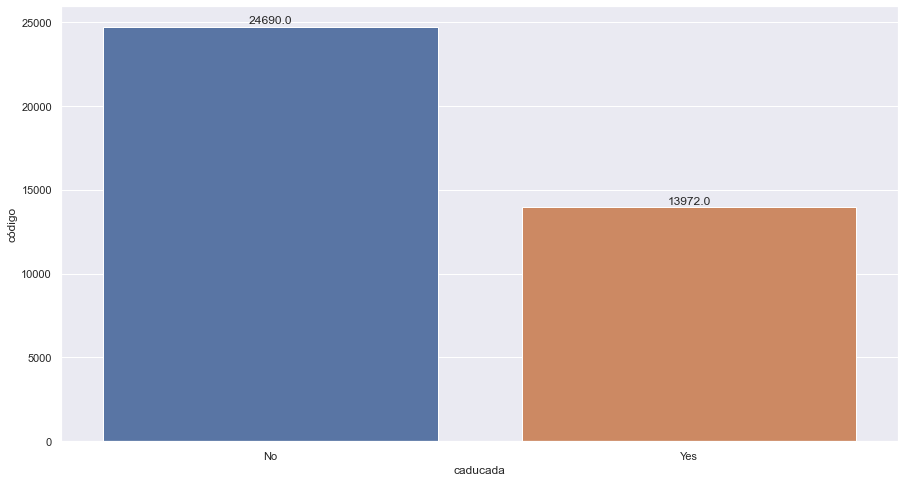

In [76]:
caducadas = data_df.groupby('caducada')['código'].nunique()

g = sns.barplot(x = caducadas.index,  y = caducadas)
show_values(g)
print(caducadas)

In [77]:
### Limpieza de fechas
from datetime import datetime
fecha_registro = []
meses = []
anios = []
dias = []
for i in range(0 ,len(data_df['fecha de registro'])):
    fecha = datetime.strptime(data_df['fecha de registro'].iloc[i],"%d/%m/%Y %H:%M")
    anio = fecha.strftime('%Y')
    mes = fecha.strftime('%m')
    dia = fecha.strftime('%d')
    fecha_registro.append(fecha)
    meses.append(mes)
    anios.append(anio)
    dias.append(dia)
data_df['fecha_registro'] = fecha_registro
data_df['mes_registro'] = meses
data_df['dia_registro'] = dias
data_df['anio registro'] = anios


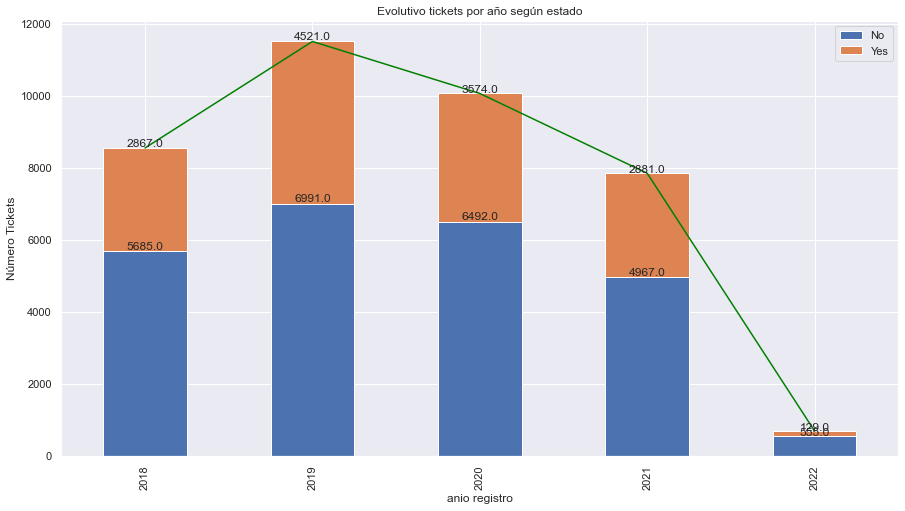

caducada,No,Yes
anio registro,,
2018,5685,2867
2019,6991,4521
2020,6492,3574
2021,4967,2881
2022,555,129


In [78]:
### Evolución de los tickets

from matplotlib.pyplot import figure


total = pd.DataFrame(data_df.groupby(['anio registro','caducada'])['código'].nunique())
total = total.reset_index()
total_df = total.pivot(index = 'anio registro', columns = 'caducada', values = 'código')
total_df.plot(kind = 'bar', stacked = True)
p = sns.lineplot(x = data_df.groupby('anio registro')['código'].nunique().index, y = data_df.groupby('anio registro')['código'].nunique(), color = 'green' )
sns.set(rc={'figure.figsize':(15,8)})
plt.title('Evolutivo tickets por año según estado')
plt.ylabel('Número Tickets')
show_values(p)
plt.show()
total_df

### Primera causa: Ineficiencia en la primera línea de atención

In [79]:
from datetime import datetime

group_accion = data_df.groupby(['caducada','acción a realizar'])['código'].nunique()
group_accion_df = pd.DataFrame(group_accion).reset_index()
porcentaje_primera = group_accion.iloc[1]/(group_accion.iloc[0] + group_accion.iloc[1])*100

print(porcentaje_primera)
group_accion_df


0.38072093965168086


,caducada,acción a realizar,código
0,No,Escalar a 2ª línea,24596
1,No,Solucionar en 1ª línea,94
2,Yes,Escalar a 2ª línea,13966
3,Yes,Solucionar en 1ª línea,6


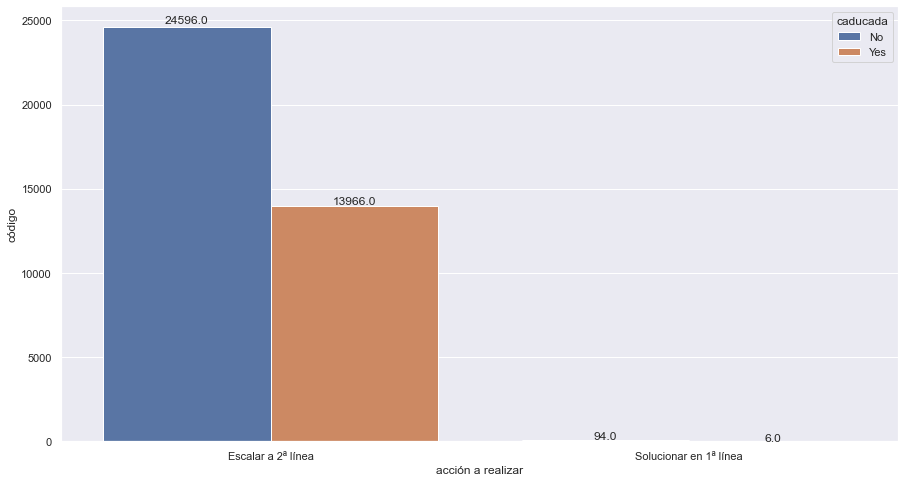

In [80]:
g = sns.barplot(x = group_accion_df['acción a realizar'], y = group_accion_df['código'], hue = group_accion_df['caducada'])
show_values(g)

Se puede observar que solamente 100 incidencias se resuelven en primera línea, lo que representa solamente el 0.25% de todos los tickets. Las incidencias que se resuelven en primera línea y caducan son mínimas en comparación a las que se escalan a segunda línea. Esto demuestra que la primera línea no resuelve todas las incidencias que debería resolver (aproximandamente el 12% según estudios).

In [81]:
### Rendimientos individuales
data_df['grupo'].unique()
data_df['grupo_asignado'] = np.where(data_df['grupo']== 'Helpdesk', 'helpdesk','equipo especializado')
data_df['grupo_asignado']

resumen = data_df.pivot_table(index = ['grupo_asignado','anio registro','grupo','tipo','categoría','tecnico_new'], values = ['tiempo_cierre_horas','sla_horas','código'], aggfunc={'tiempo_cierre_horas':np.mean,
                                                                                                                                      'sla_horas':np.mean,
                                                                                                                                      'código':'nunique'})


resumen = resumen.reset_index()

In [13]:
from powerbiclient import Report, models
from powerbiclient.authentication import DeviceCodeLoginAuthentication

In [14]:
device_auth = DeviceCodeLoginAuthentication()

Performing interactive authentication. Please follow the instructions on the terminal.
 To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code A4WB7K5VA to authenticate.
You have logged in.
Interactive authentication successfully completed.


In [143]:
group_id = '0c5a4b67-3644-4823-807b-38311f355fec'
group_id = '0c5a4b67-3644-4823-807b-38311f355fec'
report_id = 'e75642bd-ff10-4aaa-bbed-7bfe83787c16'
report = Report(group_id = group_id, report_id = report_id, auth = device_auth)

In [144]:
report

Report()

#### Tiempos de respuesta incorrectamente establecidos

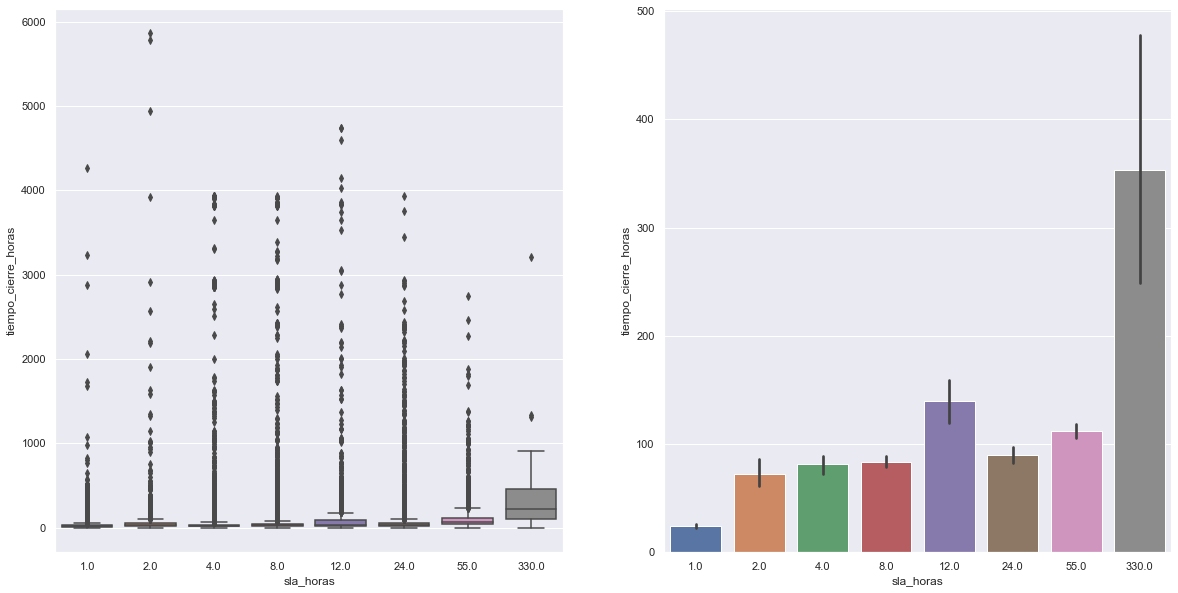

In [103]:
####
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
a = sns.boxplot(x = data_df['sla_horas'], y = data_df['tiempo_cierre_horas'], ax = ax1)
b = sns.barplot(x = data_df['sla_horas'], y = data_df['tiempo_cierre_horas'], ax = ax2)

Se puede observar que los tiempos de cierre exceden por mucho a los tiempos prometidos, a excepción del SLA de 330 horas. Esto es un indicador de que el SLA es demasiado agresivo, especialmente aquellos que son más bajos. 


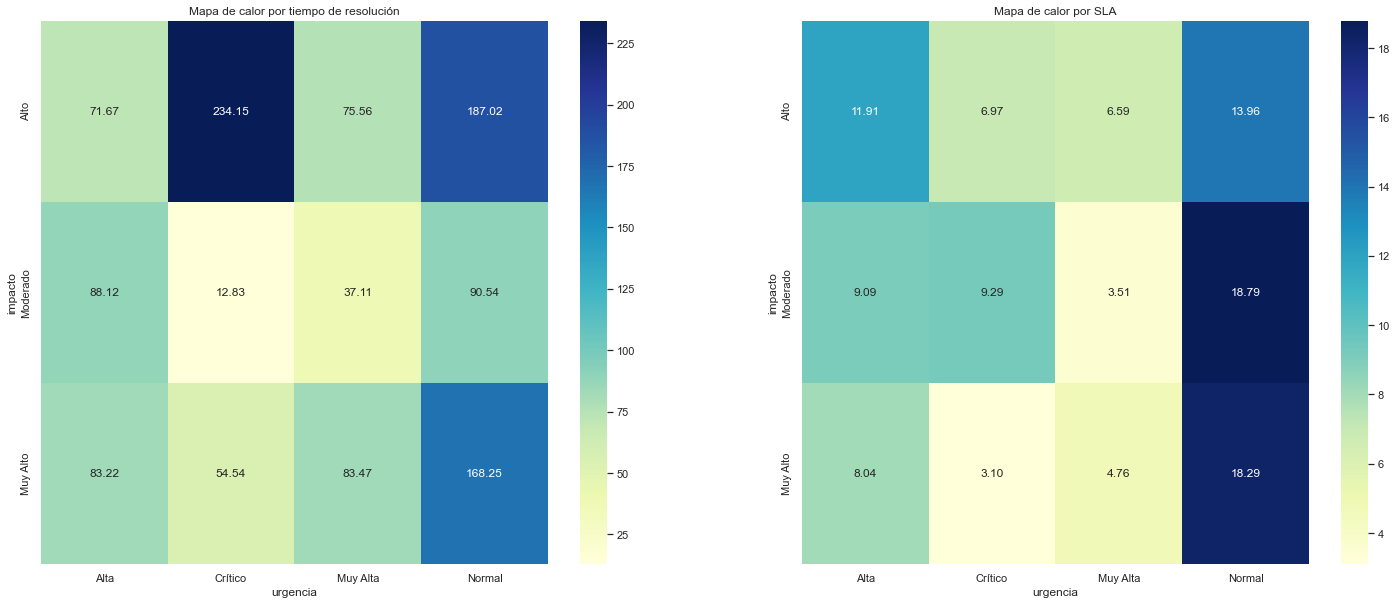

In [142]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,10))
data_cruce = pd.pivot_table(data = data_df, index = 'impacto', columns = 'urgencia', values = 'tiempo_cierre_horas', aggfunc='mean')
data_cruce_dos = pd.pivot_table(data = data_df, index = 'impacto', columns = 'urgencia', values = 'sla_horas', aggfunc='mean')
b = sns.heatmap(data_cruce_dos, annot = True, fmt= ".2f",cmap="YlGnBu")
a = sns.heatmap(data_cruce, annot = True, fmt= ".2f",cmap="YlGnBu", ax = ax1)
ax1.title.set_text('Mapa de calor por tiempo de resolución')
ax2.title.set_text('Mapa de calor por SLA')


#### Centralización de requerimientos